In [41]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [42]:
insurance = pd.read_csv("after_Obamacare.csv")

In [43]:
insurance.shape

(27684, 8)

> Drop the year variable 

In [44]:
# Drop the 'YEAR' variable
insurance = insurance.drop(columns=["YEAR"])

In [45]:
insurance.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
0,1,100.0,20.0,1.0,1.0,1,3
1,1,100.0,32.0,1.0,1.0,2,5
2,2,100.0,10.0,1.0,1.0,1,1
3,1,100.0,32.0,1.0,1.0,1,8
4,1,100.0,20.0,1.0,1.0,1,2


## Matching

In [46]:
# Convert all columns to integer type
insurance = insurance.astype(int)

In [47]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(insurance.dtypes)

Data types of each variable in the DataFrame:
SEX                int64
RACENEW            int64
INCFAM97ON2        int64
HINOTCOVE          int64
CNLUNG             int64
SMK                int64
Occupation_Code    int64
dtype: object


In [48]:
# Map 1 to 1 and 2 to 0 in the "HINOTCOVE" column
insurance["HINOTCOVE"] = insurance["HINOTCOVE"].map({1: 1, 2: 0})

# Check unique values in the "HINOTCOVE" column after mapping
unique_values = insurance["HINOTCOVE"].unique()
print(unique_values)

[1 0]


In [49]:
# Map 1 to 0 and 2 to 1 in the "CNLUNG" column
insurance["CNLUNG"] = insurance["CNLUNG"].map({1: 0, 2: 1})

# Check unique values in the "CNLUNG" column after mapping
unique_values = insurance["CNLUNG"].unique()
print(unique_values)

[0 1]


In [50]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result = model.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  345
	Unmatched treated units:  6466 out of a total of  26529 treated units
	Unmatched control units:  32 out of a total of  1155 control units
	Number of matches made this iteration:  21186
	Number of matches made so far:  21186
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.05283716907186434
Completed iteration 1 of matching
	Number of matched groups formed in total:  367
	Unmatched treated units:  6136 out of a total of  26529 treated units
	Unmatched control units:  6 out of a total of  1155 control units
	Number of matches made this iteration:  356
	Number of matches made so far:  21542
	Covariates dropped so far:  frozenset({'RACENEW'})
	Predictive error of covariate set used to match:  0.052847333848940185
Completed iteration 2 of matching
	Number of matched groups formed in total:  371
	Unmatched treated units:  6005 out of a total of  26529 treated units
	Unmat

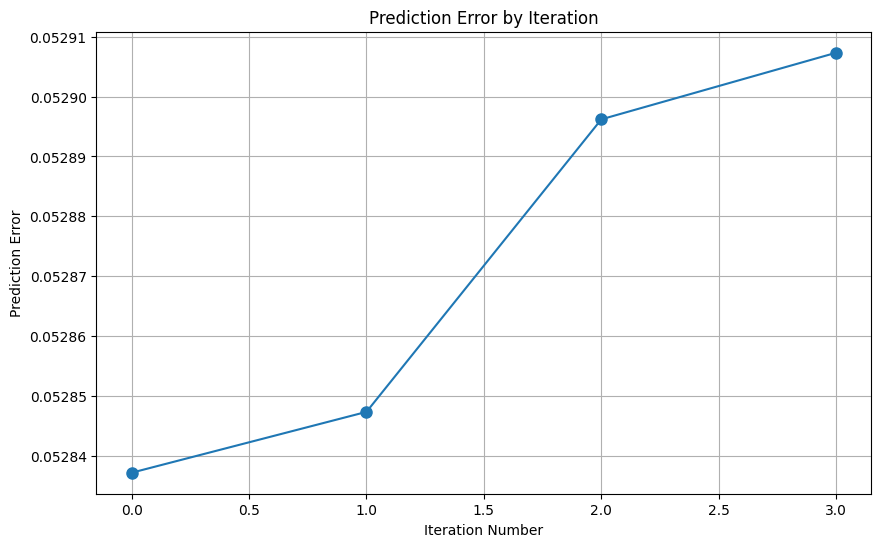

In [51]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> I choose my stopping point at iteration number 1.

In [52]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=1,  # Stop after iteration 1
)
model_new.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result_new = model_new.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  345
	Unmatched treated units:  6466 out of a total of  26529 treated units
	Unmatched control units:  32 out of a total of  1155 control units
	Number of matches made this iteration:  21186
	Number of matches made so far:  21186
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.05283716907186434
Completed iteration 1 of matching
	Number of matched groups formed in total:  367
	Unmatched treated units:  6136 out of a total of  26529 treated units
	Unmatched control units:  6 out of a total of  1155 control units
	Number of matches made this iteration:  356
	Number of matches made so far:  21542
	Covariates dropped so far:  frozenset({'RACENEW'})
	Predictive error of covariate set used to match:  0.052847333848940185
21542 units matched. We stopped after iteration 1


In [53]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [54]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code,match_group,match_group_size,weights
0,1,100,20,1,0,1,3,117.0,160.0,1.0
2,2,100,10,1,0,1,1,34.0,623.0,1.0
4,1,100,20,1,0,1,2,113.0,217.0,1.0
5,2,100,10,1,0,1,1,34.0,623.0,1.0
6,1,100,10,1,0,1,6,54.0,249.0,1.0


In [55]:
matched_data.shape

(21542, 10)

In [56]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['SEX', 'RACENEW', 'INCFAM97ON2', 'HINOTCOVE', 'CNLUNG', 'SMK',
       'Occupation_Code', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [57]:
# Model with controls except County
model_with_controls = smf.wls(
    "CNLUNG ~ HINOTCOVE + C(SEX) + C(RACENEW) + C(INCFAM97ON2) + C(SMK) + C(Occupation_Code)",
    data=matched_data,
    weights=matched_data["weights"],
).fit()

In [58]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 CNLUNG   R-squared:                       0.018
Model:                            WLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     11.32
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           4.22e-62
Time:                        18:05:02   Log-Likelihood:                 6457.2
No. Observations:               21542   AIC:                        -1.284e+04
Df Residuals:                   21506   BIC:                        -1.256e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0094      0.062      0.152      0.880      -0.112       0.131
C(SEX)[T.2]                  0.0032      0.003      1.054      0.292      -0.003       0.009
C(RACENEW)[T.200]            0.0165      0.005      3.156      0.002       0.006       0.027
C(RACENEW)[T.300]            0.0513      0.030      1.740      0.082      -0.006       0.109
C(RACENEW)[T.400]            0.0082      0.017      0.490      0.624      -0.024       0.041
C(RACENEW)[T.530]           -0.0043      0.108     -0.039      0.969      -0.217       0.208
C(RACENEW)[T.541]            0.0231      0.016      1.423      0.155      -0.009       0.055
C(INCFAM97ON2)[T.10]        -0.0045      0.005     -0.839      0.401      -0.015       0.006
C(INCFAM97ON2)[T.20]        -0.0117      0.005     -2.152      0.031      -0.022      -0.001
C(INCFAM97ON2)[T.31]        -0.0145      0.007     -2.082      0.037      -0.028      -0.001
C(INCFAM97ON2)[T.32]        -0.0237      0.006     -3.901      0.000      -0.036      -0.012
C(SMK)[T.1]                  0.0541      0.061      0.883      0.377      -0.066       0.174
C(SMK)[T.2]                  0.0147      0.061      0.239      0.811      -0.105       0.135
C(Occupation_Code)[T.1]     -0.0175      0.006     -2.698      0.007      -0.030      -0.005
C(Occupation_Code)[T.2]     -0.0063      0.007     -0.892      0.372      -0.020       0.008
C(Occupation_Code)[T.3]     -0.0121      0.007     -1.723      0.085      -0.026       0.002
C(Occupation_Code)[T.4]      0.0030      0.007      0.414      0.679      -0.011       0.017
C(Occupation_Code)[T.5]     -0.0189      0.007     -2.582      0.010      -0.033      -0.005
C(Occupation_Code)[T.6]     -0.0070      0.008     -0.850      0.395      -0.023       0.009
C(Occupation_Code)[T.7]     -0.0125      0.008     -1.528      0.126      -0.029       0.004
C(Occupation_Code)[T.8]     -0.0112      0.009     -1.310      0.190      -0.028       0.006
C(Occupation_Code)[T.9]     -0.0037      0.009     -0.419      0.675      -0.021       0.013
C(Occupation_Code)[T.10]    -0.0111      0.009     -1.271      0.204      -0.028       0.006
C(Occupation_Code)[T.11]     0.0035      0.009      0.387      0.699      -0.014       0.021
C(Occupation_Code)[T.12]     0.0037      0.009      0.393      0.694      -0.015       0.022
C(Occupation_Code)[T.13]    -0.0272      0.009     -2.861      0.004      -0.046      -0.009
C(Occupation_Code)[T.14]    -0.0157      0.010     -1.579      0.114      -0.035       0.004
C(Occupation_Code)[T.15]    -0.0150      0.014     -1.095      0.274      -0.042       0.012
C(Occupation_Code)[T.16]    -0.0275      0.013     -2.156      0.031      -0.053      -0.003
C(Occupation_Code)[T.17]    -0.0320      0.014     -2.346      0.019      -0.059      -0.005
C(Occupation_C

In [59]:
# To get the coefficient for the 'HINOTCOVE' variable
insurance_coefficient_control = model_with_controls.params["HINOTCOVE"]
print(f"Coefficient for 'HINOTCOVE' with controls: {insurance_coefficient_control:.4f}")

Coefficient for 'HINOTCOVE' with controls: 0.0057


In [60]:
# To get the p-value for the coefficient of 'HINOTCOVE' variable
insurance_p_value_control = model_with_controls.pvalues["HINOTCOVE"]
print(f"P-value for 'HINOTCOVE' with controls: {insurance_p_value_control:.4f}")

P-value for 'HINOTCOVE' with controls: 0.2917


>- The coefficient for 'HINOTCOVE' with controls (0.0057) suggests that, after controlling for other variables, there is a positive association between having insurance coverage and the outcome variable (lung cancer diagnosis status). However, the p-value associated with this coefficient (0.2917) indicates that this association is not statistically significant at conventional levels (e.g., α = 0.05). Therefore, we cannot confidently conclude that there is a significant effect of insurance coverage on lung cancer diagnosis status based on this analysis.